# 텍스트 분류

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.utils.data import DataLoader, Dataset
class MyDataset(Dataset):
    def __init__(self, data, TEXT_vocab):
        self.data = data
        self.TEXT_vocab = TEXT_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        return torch.tensor(self.TEXT_vocab(text)), torch.tensor(label)

In [ ]:
import re
from konlpy.tag import Okt # komoran, han, kkma

In [ ]:
def preprocessing(review):
    # review : 전처리할 텍스트

    okt = Okt()

    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣\s]", "", review) # 정규 표현식

    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.pos(review_text, stem=True)

    # 3. 불용어 제거
    stop_words = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
    word_review = [(token, pos) for token, pos in word_review if not token in stop_words]

    # 4. 노이즈 제거 (글자 1개는 노이즈로 간주하자.)
    word_review = [(token, pos) for token, pos in word_review if len(token) > 1]

    # 5. 명사, 동사, 형용사 추출
    word_review = [token for token, pos in word_review]
    # word_review = [token for token, pos in word_review if pos in ['Noun', 'Verb', 'Adjective']]

    return word_review

In [ ]:
import pickle
import torchtext
with open('sentiment_dataset.pkl', 'rb') as f:
    data = pickle.load(f)
train_data = data['data'][0]
valid_data = data['data'][1]
TEXT_vocab = data['vocab']

/home/kimjt/anaconda3/envs/torch/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/kimjt/anaconda3/envs/torch/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [ ]:
vocab_size = len(TEXT_vocab.vocab)
vocab_size

21034

In [ ]:
print(train_data[0])

(['이상', '이런', '드라마', '만들다', '말다', '하다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], 0)


In [ ]:
train_dataset = MyDataset(train_data, TEXT_vocab)
valid_dataset = MyDataset(valid_data, TEXT_vocab)

In [ ]:
print(train_dataset[0])

(tensor([185,  87,  26,  20, 139,   4,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]), tensor(0))


In [ ]:
BATCH_SIZE = 256

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Attention model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embedding_dim, num_heads, batch_first=True)

    def forward(self, x):
        attn_output, attn_weights = self.attention(x, x, x)  # Self-attention (query, key, value)
        return attn_output, attn_weights

class TransformerSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, output_dim):
        super(TransformerSentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # label --> latent
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embedding_dim))  # [CLS] token

        # Attention layers
        self.attention_layers = nn.ModuleList([MultiHeadSelfAttention(embedding_dim, num_heads) for _ in range(num_layers)])

        # Final classification layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        batch_size = embedded.size(0)

        # [CLS] 토큰을 문장의 앞에 추가
        cls_tokens = self.cls_token.expand(batch_size, 1, -1)  # (batch_size, 1, embedding_dim)
        x = torch.cat((cls_tokens, embedded), dim=1)  # (batch_size, seq_len+1, embedding_dim)

        x, attn_weights = self.attention_layers[-1](x)  # 마지막 레이어에서만 Attention Weight 반환

        # [CLS] 토큰의 벡터를 가져와서 최종 감성 분류
        cls_output = x[:, 0, :]  # (batch_size, embedding_dim)
        output = self.fc(cls_output)  # (batch_size, output_dim)
        # logistic 0~1

        return output, attn_weights  # 최종 Attention Score만 반환

In [ ]:
try:
    del model
    torch.cuda.empty_cache()
except:
    pass

embedding_dim = 128
num_heads = 8
num_layers = 3
output_dim = 1  # 이진 분류

# 모델 초기화
model = TransformerSentimentClassifier(vocab_size, embedding_dim, num_heads, num_layers, output_dim).cuda()
criterion = nn.BCEWithLogitsLoss()  # 이진 분류에 사용
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in tqdm(train_loader):
        optimizer.zero_grad()
        output, _ = model(X_batch.cuda())
        loss = criterion(output.squeeze(1), y_batch.float().cuda())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for X_batch, y_batch in valid_loader:
            output, _ = model(X_batch.cuda())
            val_loss = criterion(output.squeeze(1), y_batch.float().cuda())
            total_val_loss += val_loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(valid_loader):.4f}')

  0%|          | 0/461 [00:00<?, ?it/s]

100%|██████████| 461/461 [00:06<00:00, 75.50it/s]


Epoch 1/10, Loss: 0.4956, Val Loss: 0.4206


100%|██████████| 461/461 [00:06<00:00, 71.03it/s]


Epoch 2/10, Loss: 0.3970, Val Loss: 0.3958


100%|██████████| 461/461 [00:06<00:00, 74.19it/s]


Epoch 3/10, Loss: 0.3624, Val Loss: 0.3884


100%|██████████| 461/461 [00:05<00:00, 80.85it/s]


Epoch 4/10, Loss: 0.3366, Val Loss: 0.3943


100%|██████████| 461/461 [00:06<00:00, 74.62it/s]


Epoch 5/10, Loss: 0.3135, Val Loss: 0.4011


100%|██████████| 461/461 [00:06<00:00, 73.00it/s]


Epoch 6/10, Loss: 0.2920, Val Loss: 0.4120


100%|██████████| 461/461 [00:06<00:00, 74.52it/s]


Epoch 7/10, Loss: 0.2717, Val Loss: 0.4389


100%|██████████| 461/461 [00:06<00:00, 75.05it/s]


Epoch 8/10, Loss: 0.2522, Val Loss: 0.4597


100%|██████████| 461/461 [00:06<00:00, 71.21it/s]


Epoch 9/10, Loss: 0.2344, Val Loss: 0.4696


100%|██████████| 461/461 [00:06<00:00, 76.15it/s]


Epoch 10/10, Loss: 0.2181, Val Loss: 0.4974


0 진짜 영화 진심 재미 없네요. 알바 푼거 성공한듯. 별 반개도 아까움
['진짜', '영화', '진심', '재미', '없다', '알바', '풀다', '성공하다', '반개', '아깝다']


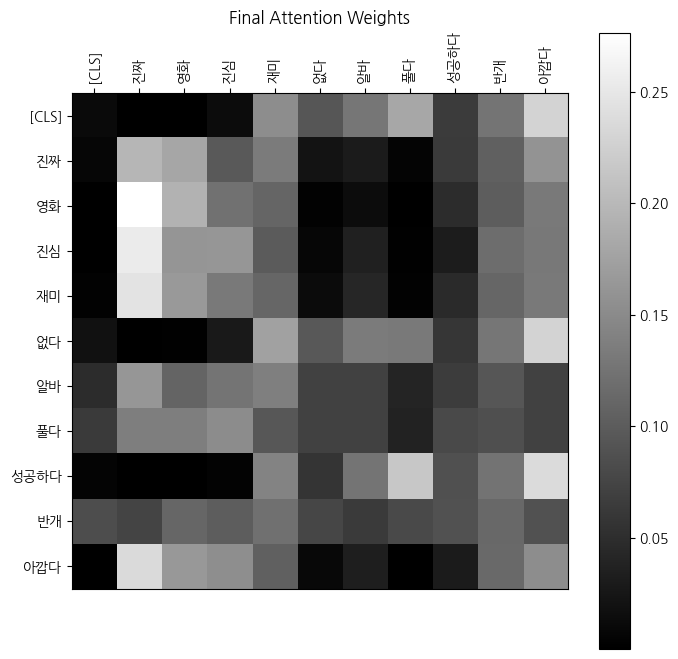

1 평론가들 왜저러는지 노이해;차태현 나오면 다 좋지만 이건 특히나 더 좋음
['평론가', '저러다', '이해', '차태현', '나오다', '좋다', '이건', '특히', '좋다']


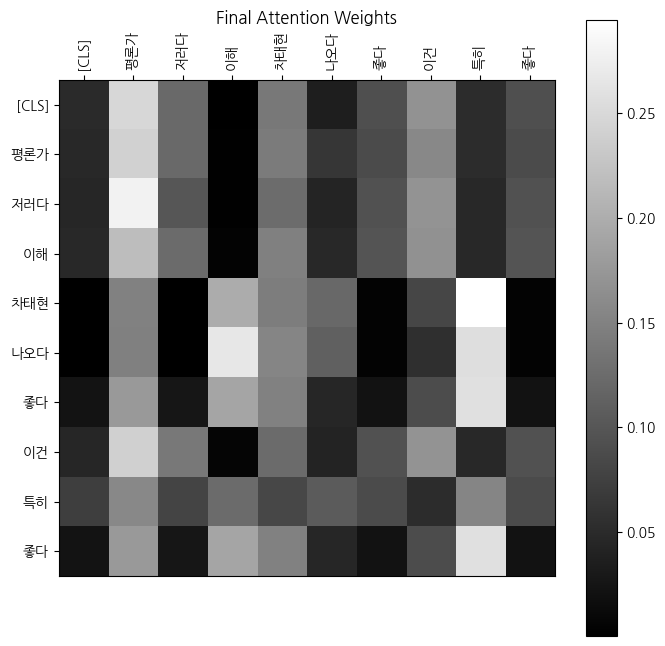

In [ ]:
import matplotlib.pyplot as plt

# Attention score 시각화 함수
def visualize_attention(model, sentence, label):
    model.eval()
    tkn_text = preprocessing(sentence)
    input_tensor = torch.tensor(TEXT_vocab(tkn_text)).unsqueeze(0)

    with torch.no_grad():
        output, attn_weights = model(input_tensor.cuda())

    pred = 'Positive' if output.item() > 0 else 'Negative'
    attn_weights = attn_weights.squeeze(0).detach().cpu().numpy()  # (seq_len+1, seq_len+1)에서 첫 번째 배치 선택

    # [CLS] 토큰 포함한 전체 attention 시각화
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(attn_weights, cmap='gray')

    # CLS 토큰 포함한 토큰 리스트 생성
    tokens_with_cls = ["[CLS]"] + tkn_text

    ax.set_xticks(range(len(tokens_with_cls)))
    ax.set_yticks(range(len(tokens_with_cls)))
    ax.set_xticklabels(tokens_with_cls, rotation=90)
    ax.set_yticklabels(tokens_with_cls)

    # X축 tick을 위쪽에 배치
    ax.xaxis.set_ticks_position('top')

    # Colorbar 추가
    plt.colorbar(im)
    plt.title("Final Attention Weights")
    plt.show()


sample = text_df.sample(2, random_state = 1004)
model.eval()
for idx, row in sample.iterrows():
    sentence = row['document']
    label = row['label']

    print(label, sentence)
    print(preprocessing(sentence))
    try:
        visualize_attention(model, sentence,label)
    except:
        pass



-  positional encoding 추가 --> 자연어 시계열 모델로 수정
-  head num, attention layer의 개수에 따라 최고 성능의 변화를 그래프로 그려보기